# Exercise 2.5

Design and conduct an experiment to demonstrate the diffculties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the q*(a) start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the q*(a) on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha$ =0.1. Use $\epsilon$ =0.1 and longer runs, say of 10,000 steps.

In [26]:
import numpy as np
import matplotlib.pyplot as plt

Let's begin by creating a class for the bandit problem. We will make it similar to the 10-armed testbed described in chapter 2.3.

In [27]:
class Bandit():
    def __init__(self, k=10, var=1, random_step=(0, 0.01)):
        # Number of arms
        self.k = k

        # Initialize action values to 0
        self.action_values = np.zeros(k)

        # Standard deviation for actual reward distributions
        self.stddev = var**(0.5)

        # Mean and standard deviation of one step of random walk of action values
        self.random_step = random_step

    # Function for agent to execute action
    def step(self, action):
        assert action in range(self.k)
        
        # Draw reward
        reward = np.random.normal(self.action_values[action], self.stddev)

        # Step random walk for action values
        steps = np.random.normal(self.random_step[0], self.random_step[1], size=self.k)
        self.action_values = self.action_values + steps

        # Check if action was optimal
        was_optimal = 1 if action == np.argmax(self.action_values) else 0

        return reward, was_optimal

Now let's create a class for the action-value agents, in this case $\epsilon$-greedy.

In [28]:
class Action_value_agent():
    def __init__(self, epsilon=0.1, k=10, problem=None, step_size=None):
        # Probability of exploration
        self.epsilon = epsilon
        
        # Number of actions to choose from
        self.k = k

        # Initialize state estimates to 0
        self.states = np.zeros(k)

        # Problem to solve
        self.problem = problem

        # Step-size, if empty then we use inverse of step counter as step size.
        self.step_size = step_size

        # Initialize step counter
        self.n = 1

        # Number of optimal actions
        self.optimal_n = 0

        # Cumulative reward
        self.cumulatve_r = 0

    def act(self):
        # Greedily select next action
        action = np.argmax(self.states)

        # Explore with a probability of epsilon
        if np.random.rand(1) <= self.epsilon:
            action = np.random.randint(self.k)
        
        # Act
        reward, was_optimal = self.problem.step(action)

        # Get step-size
        step_size = self.step_size if self.step_size else 1/self.n

        # Incrementally calculate new estimate
        self.states[action] = self.states[action] + step_size*(reward - self.states[action])

        self.cumulatve_r += reward
        self.optimal_n += was_optimal
        self.n += 1

    # Getter functions for the average reward and % of optimal actions
    def get_average_reward(self):
        return self.cumulatve_r/self.n
    
    def get_optimal_action(self):
        return self.optimal_n/self.n

Now let's create the two described agent and let them loose.

In [29]:
N = 10000
# Step-size for constant agent
alpha = 0.1

# Arrays to contain performance data
average_reward_1 = np.zeros([N,2000])
average_reward_2 = np.zeros([N,2000])

optimal_action_1 = np.zeros([N,2000])
optimal_action_2 = np.zeros([N,2000])

# We make a testbed of 2000 bandit problems
for i in range(2000):
    bandit = Bandit()
    
    av_agent = Action_value_agent(problem=bandit)
    av_agent_constant = Action_value_agent(problem=bandit, step_size=alpha)

    for t in range(N):
        av_agent.act()
        av_agent_constant.act()
        
        # Collect the data
        average_reward_1[t,i] = av_agent.get_average_reward()
        optimal_action_1[t,i] = av_agent.get_optimal_action()
        optimal_action_2[t,i] = av_agent_constant.get_optimal_action()
        average_reward_2[t,i] = av_agent_constant.get_average_reward()

average_reward_1 = np.mean(average_reward_1,axis=1)
optimal_action_1 = np.mean(optimal_action_1,axis=1)
optimal_action_2 = np.mean(optimal_action_2,axis=1)
average_reward_2 = np.mean(average_reward_2,axis=1)


AxisError: axis 1 is out of bounds for array of dimension 0

Let's plot the data.

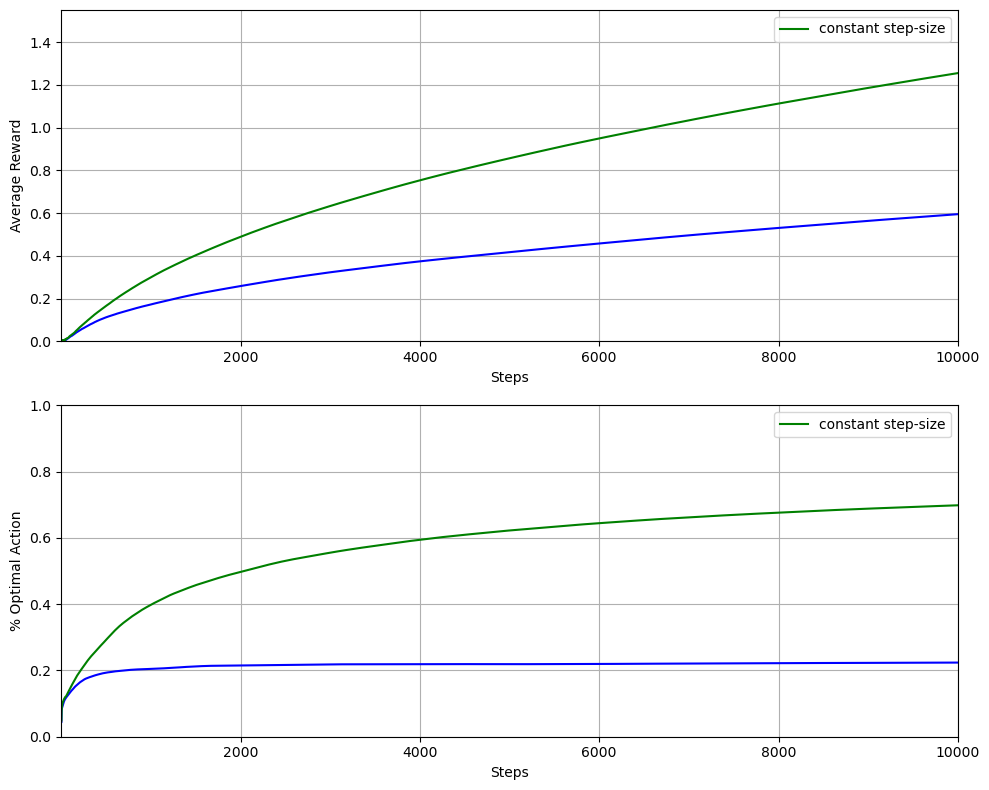

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

steps = np.array(range(1,N+1))
# Plotting the "Average Reward" subplot without title
ax1.plot(steps, average_reward_1, color='blue')
ax1.plot(steps, average_reward_2, label='constant step-size', color='green')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Average Reward')
ax1.set_xlim(1, 10000)
ax1.set_ylim(0, 1.55)
ax1.legend()
ax1.grid(True)

# Plotting the "% Optimal Action" subplot without title
ax2.plot(steps, optimal_action_1, color='blue')
ax2.plot(steps, optimal_action_2, label='constant step-size', color='green')
ax2.set_xlabel('Steps')
ax2.set_ylabel('% Optimal Action')
ax2.set_xlim(1, 10000)
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()